### Import Libraries Here

In [1]:
# import all the necessary libraries/packages here
import os
import pandas as pd
from scipy.signal import windows, find_peaks
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from functools import partial
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import shap

2024-12-13 19:38:48.810369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 19:38:48.811418: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 19:38:48.815430: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 19:38:48.827775: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734147528.847929   14390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734147528.85

### Radar Parameters from the Reference Paper [here](https://arxiv.org/pdf/2310.08876)

The following parameters are provided in the reference paper:

- **Frequency Range**: 
  - $f_{\mathrm{min}} = 58.5~\mathrm{GHz}$ to $f_{\mathrm{max}} = 62.5~\mathrm{GHz}$  
    The radar operates within this frequency range.

- **Range Resolution**: 
  - $\Delta R = 0.0375~\mathrm{m}$  
    The minimum detectable distance by the radar.

- **Maximum Resolvable Range**: 
  - $R_{\mathrm{max}} = 1.2~\mathrm{m}$  
    The maximum distance that the radar can detect.

- **Pulse Repetition Time**: 
  - $T_{\mathrm{PRT}} = 300~\mathrm{\mu s}$  
    The time interval between successive chirps emitted by the radar.

- **Number of Chirps**: 
  - $M = 32$  
    The number of chirps used in each radar frame.

- **Frame Rate**: 
  - $f_{\mathrm{frame}} = 33.3~\mathrm{Hz}$  
    The frequency at which the radar captures frames.

### Derived Parameters

From the above parameters, the following derived values can be calculated:

- **Bandwidth**: 
  - $f_{\mathrm{BW}} = 4~\mathrm{GHz}$  
    The radar's operating bandwidth.

- **Maximum Doppler Shift**: 
  - $f_{\mathrm{b,max}} = 1~\mathrm{MHz}$  
    The maximum Doppler shift detectable by the radar.

- **Chirp Duration**: 
  - $T_{\mathrm{c}} = 32~\mathrm{\mu s}$  
    The duration of each chirp.

- **Range Velocity Resolution**: 
  - $v_{\mathrm{res}} > 0.2604~\mathrm{m/s}$  
    The minimum detectable velocity along the range.

- **Maximum Velocity**: 
  - $v_{\mathrm{max}} = 4.166~\mathrm{m/s}$  
    The maximum detectable velocity by the radar.

- **Angular Resolution**: 
  - $\Delta\theta > 57^{\circ}$  
    The angular resolution of the radar.

- **Max Angle Range**: 
  - $-90^{\circ} < \theta_{\mathrm{max}} < 90^{\circ}$  
    The maximum detectable angular range of the radar.

- **Bin Distance**:  
  $\frac{R_{\mathrm{max}}}{\mathrm{Num\_bins}} = 0.03637~\mathrm{m}$  
  The distance represented by each range bin.

- **Doppler Values**:  
  $\text{doppler\_values} = \text{np.arange}(-\mathrm{num\_chirps} // 2, \mathrm{num\_chirps} // 2) \times -0.2604~\mathrm{m/s}$  
  Doppler velocity values calculated based on the number of chirps and the Doppler resolution.

---

### Radar Equations Used for Calculation of Derived Parameters

#### Physical Constants:
- $c$: speed of light

#### Radar Waveform and Hardware Parameters:
- $f_{\mathrm{min}}$: start frequency of the chirp
- $f_{\mathrm{max}}$: end frequency of the chirp
- $f_{\mathrm{BW}}$: bandwidth of the chirp, $f_{\mathrm{max}} - f_{\mathrm{min}}$
- $f_{\mathrm{c}}$: center frequency of the chirp, $\frac{f_{\mathrm{max}} + f_{\mathrm{min}}}{2}$
- $T_{\mathrm{c}}$: duration of the chirp
- $T_{\mathrm{PRT}}$: pulse repetition time, the distance between two chirps
- $M$: number of chirps
- $N_{\mathrm{ant}}$: number of antennas
- $f_{\mathrm{frame}}$: frame rate
- $d$: distance between antenna elements
- $f_{\mathrm{s}}$: sampling rate of the analog-to-digital converter (ADC)

#### Derived Parameters:
- $\lambda_{\mathrm{c}} = \frac{c}{f_{\mathrm{c}}}$: center frequency wavelength
- $K = \frac{f_{\mathrm{max}} - f_{\mathrm{min}}}{T_{\mathrm{c}}}$: slope of the chirp waveform
- $f_{\mathrm{b,max}} = \frac{f_{\mathrm{s}}}{2}$: maximum beat frequency (Nyquist theorem)
- $\phi_{12} = \frac{2\pi d \sin\theta}{\lambda_{\mathrm{c}}}$: angle derived from phase comparison monopulse

#### Range Calculations:
- $\Delta R = \frac{c}{2 f_{\mathrm{BW}}}$: minimum resolvable distance
- $R_{\mathrm{max}} = \frac{c f_{\mathrm{b,max}}}{2K}$: maximum distance

#### Doppler (Radial Speed) Calculations:
- $v_{\mathrm{res}} \geq \frac{\lambda_{\mathrm{c}}}{2 M T_{\mathrm{PRT}}}$: minimum resolvable radial speed
- $v_{\mathrm{max}} = \pm \frac{\lambda_{\mathrm{c}}}{4 T_{\mathrm{PRT}}}$: maximum radial speed

#### Angular Calculations:
- $\Delta \theta > \frac{\lambda_{\mathrm{c}}}{2d}$: minimum resolvable angle
- $\theta_{\mathrm{max}} < \sin^{-1}\left(\frac{\lambda_{\mathrm{c}}}{M d \cos(\theta)}\right)$

### Radar Model: BGT60LTR13C

From the article, the radar used is **BGT60LTR13C**:

- **Number of Antennas (Vertical/Horizontal)**: $N_{\mathrm{ant,v/h}} = 2$  
  The radar has 2 vertical and 2 horizontal antennas, which can be used for angle resolution.

- **Antenna Spacing**: $d = \frac{\lambda_{\mathrm{c}}}{2}$  
  The spacing between antenna elements for each dimension.


# Feature Extraction Functions  
These functions process raw signal data to generate range profiles and range-Doppler profiles, while also extracting features from both profiles for further analysis.

#### Overview:  
These functions were developed through:  
- **Insights and methods outlined in the [reference paper](https://arxiv.org/pdf/2310.08876).**
- **Exploratory Data Analysis (EDA) experiments**  (For EDA experiments, please refer to the other notebook.)


In [2]:
def generate_range_profiles(data: np.ndarray) -> np.ndarray:
    """
    Compute the range FFT for each (n_frame, n_antenna, n_chirp, n_sample) matrix.

    The resulting spectrum:
    - Eliminates quasi-static targets.
    - Retains only the positive spectrum.
    - Integrates the range signal over multiple chirps and receiver antennas 
      to improve the signal-to-noise ratio (SNR).

    Args:
        data (np.ndarray): Input matrix for a single frame of size 
                           (n_frame, n_antenna, n_chirp, n_sample).

    Returns:
        np.ndarray: Integrated range spectrum with shape (n_frame, n_sample // 2 + 1).
    """
    # Extract the number of frames, antennas, chirps, and samples
    n_frame, n_antenna, n_chirp, n_sample = data.shape

    # Step 1: Remove the DC bias (mean) along the sample dimension
    data_centered = data - np.mean(data, axis=-1, keepdims=True)

    # Step 2: Apply the Blackman-Harris window to reduce spectral leakage
    window = windows.blackmanharris(n_sample).reshape(1, n_sample) # Shape for broadcasting
    data_windowed = data_centered * window

    # Step 3: Perform FFT along the sample axis and normalize by window
    range_fft = np.fft.fft(data_windowed, axis=-1) / np.sum(window)

    # Step 4: Remove quasi-static targets by subtracting the mean over chirps
    range_fft -= np.mean(range_fft, axis=2, keepdims=True)

    # Step 5: Retain only the positive spectrum and scale non-DC components
    range_fft_half = range_fft[..., :n_sample // 2 + 1]
    range_fft_half[..., 1:] *= 2  # Double the amplitude (excluding DC component)

    # Step 6: Integrate over antennas and chirps to improve SNR
    integrated_range_fft = np.sum(np.abs(range_fft_half), axis=(1, 2)) / (n_antenna * n_chirp)

    return integrated_range_fft

In [3]:
def detect_hand_position(data: np.ndarray, n_skip: int = 3) -> np.ndarray:
    """
    Detect the position of the maximum signal in the integrated range profiles 
    relative to the radar sensor.

    Args:
        data (np.ndarray): Integrated range spectrum with shape (n_frame, n_sample // 2 + 1).
        n_skip (int): Number of bins to skip from the beginning for range determination.

    Returns:
        np.ndarray: Indices of the maximum peak to the radar sensor for all frames, 
                    with shape (n_frame,).
    """
    # Validate inputs
    if n_skip < 0:
        raise ValueError("n_skip must be a non-negative integer.")
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D array with shape (n_frame, n_sample // 2 + 1).")

    # Detect the position of the maximum signal after skipping the specified bins
    range_bins = np.argmax(data[:, n_skip:], axis=1)

    # Adjust range_bins to account for the skipped bins
    range_bins += n_skip

    return range_bins


In [4]:
def calculate_range(data: np.ndarray, n_skip: int = 3, bin_distance: float = 0.03637) -> np.ndarray:
    """
    Calculate the range (in meters) of the maximum signal in the integrated range profiles
    relative to the radar sensor.

    Args:
        data (np.ndarray): Integrated range spectrum with shape (n_frame, n_sample // 2 + 1).
        n_skip (int): Number of initial bins to skip for range determination.
        bin_distance (float): Distance represented by each range bin (in meters) calculated from reference paper parameters.

    Returns:
        np.ndarray: Position of the maximum signal in meters for all frames, with shape (n_frame).
    """
    # Detect the range bins corresponding to the maximum signal
    range_bins = detect_hand_position(data, n_skip)

    # Convert range bins to physical distance in meters
    range_meters = range_bins * bin_distance

    return range_meters

In [5]:
def generate_range_doppler_profiles_per_antenna(data: np.ndarray) -> np.ndarray:
    """
    Compute the range-Doppler profile for each (n_frame, n_antenna, n_chirp, n_sample) matrix.

    Args:
        data (np.ndarray): Input matrix for of size 
                           (n_frame, n_antenna, n_chirp, n_sample).

    Returns:
        np.ndarray: Range-Doppler profile with shape (n_frame,n_antenna, n_chirp, n_sample // 2 + 1).
    """
    # Extract the number of frames, antennas, chirps, and samples
    n_frame, n_antenna, n_chirp, n_sample = data.shape

    # Step 1: Remove the DC bias (mean) along the sample dimension
    data_centered = data - np.mean(data, axis=-1, keepdims=True)
    
    # Step 2: Apply the Blackman-Harris window to reduce spectral leakage
    range_window = windows.blackmanharris(n_sample).reshape(1, n_sample) # Shape for broadcasting
    data_windowed = data_centered * range_window

    # Step 3: Perform FFT along the sample axis and normalize by the window sum
    range_fft = np.fft.fft(data_windowed, axis=-1) / np.sum(range_window)

    # Step 4: Remove quasi-static targets by subtracting the mean over chirps
    range_fft -= np.mean(range_fft, axis=2, keepdims=True)

    # Step 5: Retain only the positive spectrum
    range_fft_half = range_fft[..., :n_sample // 2 + 1]
    range_fft_half[:,:,:,1::-1] = 2*range_fft_half[:,:,:,1::-1]

    # Step 6: Apply the Blackman-Harris window to the chirp axis
    doppler_window = windows.blackmanharris(n_chirp).reshape(1, 1, n_chirp, 1)
    range_fft_half_windowed = range_fft_half * doppler_window


    # Step 7: Perform FFT on the chirp axis and apply FFT shift for Doppler centering
    range_doppler = np.fft.fftshift(np.fft.fft(range_fft_half_windowed, axis=2), axes=2)/np.sum(doppler_window)

    return range_doppler

In [6]:
def generate_range_doppler_profiles(data: np.ndarray) -> np.ndarray:
    """
    Computes the summed range-Doppler profile over antennas.

    Args:
        data (np.ndarray): Input matrix of shape 
                           (n_frame, n_antenna, n_chirp, n_sample).

    Returns:
        np.ndarray: Range-Doppler profile with shape (n_frame, n_chirp, n_sample // 2 + 1).
    """
    # Validate input dimensions
    if data.ndim != 4:
        raise ValueError("Input data must be a 4D array with shape (n_frame, n_antenna, n_chirp, n_sample).")
    
    n_frame, n_antenna, n_chirp, n_sample = data.shape
    
    # Compute range-Doppler profiles for each antenna
    range_doppler = generate_range_doppler_profiles_per_antenna(data)
    
    # Integrate the absolute FFT data across antennas
    integrated_range_doppler = np.sum(np.abs(range_doppler), axis=1) / n_antenna

    return integrated_range_doppler

In [7]:
def calculate_doppler_bins(range_doppler_profiles: np.ndarray, range_bins: np.ndarray) -> np.ndarray:
    """
    Retrieves the indices for the maximum Doppler shift for each provided range bin.

    Args:
        range_doppler_profiles (np.ndarray): A 3D array representing the range-Doppler map with shape 
                                        (n_frame, n_chirp, n_sample).
        range_bins (np.ndarray): A 1D array of range bin indices to search for the maximum Doppler shift.

    Returns:
        np.ndarray: A 1D array containing the indices of the maximum Doppler shift for each range bin.
    """
    # Validate input shapes
    if range_doppler_profiles.ndim != 3:
        raise ValueError("Input range_doppler_profiles must be a 3D array with shape (n_frame, n_chirp, n_sample).")
    
    if range_bins.ndim != 1:
        raise ValueError("Input range_bins must be a 1D array.")
    
    # Ensure that the provided range bins are within the valid range
    if np.any(range_bins >= range_doppler_profiles.shape[1]):
        raise ValueError(f"Some range_bins indices exceed the number of available range bins: {range_doppler_profiles.shape[1]}")

    doppler_bins = [
        np.argmax(np.abs(frame[:, i]))  # Find the index of max Doppler shift for each frame
        for i, frame in zip(range_bins, range_doppler_profiles)
    ]
    
    return np.array(doppler_bins)

In [8]:
def calculate_radial_speed(range_doppler_profiles: np.ndarray, range_bins: np.ndarray, num_chirps: int = 32) -> np.ndarray:
    """
    Calculate the radial speed (Doppler velocity) in meters per second 
    from the range-Doppler map and range bins.

    Args:
        range_doppler_profiles (np.ndarray): range_doppler_profiles with shape 
                                        (n_frames, n_chirps, n_range_bins).
        range_bins (np.ndarray): Detected range bins for each frame, shape (n_frames,).
        num_chirps (int): Number of chirps in a frame (default: 32).

    Returns:
        np.ndarray: Radial speed in meters per second for each frame, shape (n_frames,).
    """
    # Calculate Doppler bins for each frame based on the range bins
    doppler_bins = calculate_doppler_bins(range_doppler_profiles, range_bins)
    
    # Generate Doppler velocity values for the chirp indices
    doppler_resolution = -0.2604  # Velocity resolution in meters/second per bin
    doppler_values = np.arange(-num_chirps // 2, num_chirps // 2) * doppler_resolution

    # Map Doppler bins to corresponding velocity values
    doppler_speeds = doppler_values[doppler_bins]

    return doppler_speeds

In [9]:
def calculate_signal_magnitude(
    range_doppler_profiles: np.ndarray, 
    range_bins: np.ndarray, 
    doppler_bins: np.ndarray
) -> np.ndarray:
    """
    Calculate the signal magnitude for each frame across 100 frames, 
    using the specified Doppler and range bins.

    Parameters:
        range_doppler_profiles (np.ndarray): 3D array of shape (n_frame, n_chirp, n_sample // 2 + 1), 
                                             representing the range-Doppler profiles.
        range_bins (np.ndarray): 1D array of range bin indices for each frame (shape: n_frames).
        doppler_bins (np.ndarray): 1D array of Doppler bin indices for each frame (shape: n_frames).

    Returns:
        np.ndarray: 1D array of signal magnitudes for each frame (shape: n_frames).
    """
    # Validate input dimensions
    n_frames = range_doppler_profiles.shape[0]
    if len(range_bins) != n_frames or len(doppler_bins) != n_frames:
        raise ValueError(
            "Lengths of range_bins and doppler_bins must match the number of frames in range_doppler_profiles."
        )

    # Calculate the signal magnitude for each frame
    signal_magnitude = range_doppler_profiles[np.arange(n_frames), doppler_bins, range_bins]

    return signal_magnitude

In [10]:
def extract_angles(
    range_doppler_profiles_per_antenna: np.ndarray, 
    doppler_bins: np.ndarray, 
    range_bins: np.ndarray
) -> tuple:
    """
    Extracts horizontal and vertical angles from range-Doppler profiles for each antenna.

    Args:
        range_doppler_profiles_per_antenna (np.ndarray): Input array of shape 
                                                         (n_frame, n_antenna, n_chirp, n_sample).
        doppler_bins (np.ndarray): Array of Doppler bin indices for each frame (shape: n_frames).
        range_bins (np.ndarray): Array of range bin indices for each frame (shape: n_frames).

    Returns:
        tuple: A tuple containing:
            - angle_horizontal (np.ndarray): Horizontal angles (shape: n_frames).
            - angle_vertical (np.ndarray): Vertical angles (shape: n_frames).
    """
    # Validate input dimensions
    n_frame, n_antenna, n_chirp, n_sample = range_doppler_profiles_per_antenna.shape
    if n_antenna < 3:
        raise ValueError("The input data must have at least 3 antennas to extract angles.")
    
    if len(doppler_bins) != n_frame or len(range_bins) != n_frame:
        raise ValueError("doppler_bins and range_bins must match the number of frames.")
    
    # Extract received signals for each antenna
    received_signals = np.vstack([
        range_doppler_profiles_per_antenna[
            np.arange(n_frame), antenna_idx, doppler_bins, range_bins
        ]
        for antenna_idx in range(n_antenna)
    ])

    # Compute phase differences for horizontal and vertical angles
    phase_horizontal = (np.mod(
        np.angle(received_signals[1]) - np.angle(received_signals[2]) + np.pi, 2 * np.pi
    ) - np.pi) / np.pi
    angle_horizontal = np.arcsin(phase_horizontal)

    phase_vertical = (np.mod(
        np.angle(received_signals[0]) - np.angle(received_signals[2]) + np.pi, 2 * np.pi
    ) - np.pi) / np.pi
    angle_vertical = np.arcsin(phase_vertical)

    return angle_horizontal, angle_vertical



In [11]:
def select_frames(range_: np.ndarray, num_frames: int = 10) -> np.ndarray:
    """
    Selects a sequence of frames starting from the frame where the actual gesture takes place.
    Args:
        range_profiles (np.ndarray): Array representing the range-.
        num_frames (int): Number of frames to select, starting from the frame 
                          of minimum hand-to-radar distance. Default is 10.

    Returns:
        np.ndarray: Indices of the selected frames.
    """

    # Select frames 
    start_idx = 30
    selected_frames = np.arange(start_idx, start_idx + num_frames, 1)
    
    return selected_frames

# SECTION 1
## Modeling with Range-Doppler Profiles

Modeling with **range-Doppler profiles** involves using two-dimensional radar data, where:  
- The **range axis** represents the object's distance from the radar.  
- The **Doppler axis** represents the object's relative velocity with respect to the radar.  

In this approach, deep learning models are utilized to extract and learn hidden features directly from the range-Doppler profiles. 

To implement this method, raw radar signals must first be processed and converted into range-Doppler profiles using appropriate signal processing techniques and preprocessing functions.



# Part 1: Load Data  

- **Data Overview**:  
  Radar signals are stored as NumPy arrays with a shape of `(100x3x32x64)`, resulting in a total data size of 52 GB.
- **Solution**:  
  **Range-doppler profiles** will be extracted iteratively using the preprocessed functions created earlier and saved to **numpy arrays**.
  

In [12]:
DATA_FOLDER = './fulldata'

# Initialize a dictionary to store the data
full_data_range_doppler = {
    'file_name':[],
    'range_doppler':[],
    'gesture_name': []
}

# Iterate over files in the data folder
for i, file_name in enumerate(os.listdir(DATA_FOLDER)):
    # Construct the full path to the file
    full_data_path = os.path.join(DATA_FOLDER, file_name)

    # upload data
    data = np.load(full_data_path)
  
    # calculate doppler
    integrated_range_doppler_profiles = generate_range_doppler_profiles(data)
    full_data_range_doppler['range_doppler'].append(integrated_range_doppler_profiles)
    
    # Parse the filename to extract labels (gesture names)
    try:
        gesture_name, environment_label, user_label, _ = file_name.split('_')
        full_data_range_doppler['gesture_name'].append(gesture_name)
        full_data_range_doppler['file_name'].append(file_name)
    except ValueError:
        print(f"Filename format is incorrect: {file_name}")
        continue  # Skip if the filename format is invalid



### Create NumPy Arrays for Range-Doppler Features and Target Variable

In [13]:
# Convert the 'range_doppler' column to a NumPy array and save it to a file
full_data_range_doppler['range_doppler'] = np.array(full_data_range_doppler['range_doppler'])
np.save('doppler_range.npy', full_data_range_doppler['range_doppler'])

# Define a dictionary mapping gestures to numeric labels
gesture_dict = {
    'SwipeLeft': 0,
    'SwipeRight': 1,
    'SwipeDown': 2,
    'SwipeUp': 3,
    'Push': 4
}

# Generate the target labels based on the gesture dictionary
target = [gesture_dict[gesture] for gesture in full_data_range_doppler['gesture_name']]

# Convert the target list to a NumPy array and save it to a file
target = np.array(target)
np.save('gesture_labels.npy', target)


### Splitting Data into Training and Testing Sets

In [14]:
X_train, X_test_valid, y_train, y_test_valid  = train_test_split(full_data_range_doppler['range_doppler'], target, test_size=0.5, shuffle=True)
X_test, X_valid, y_test, y_valid  = train_test_split(X_test_valid, y_test_valid, test_size=0.5, shuffle=True)

In [15]:
num_data, sequence_length, map_height, map_width = X_train.shape
num_classes = len(np.unique(target))
print("Number of data points:", num_data)
print("Number of range-Doppler maps in a sequence:", sequence_length)
print("Dimensions of each range-Doppler map:", (map_height, map_width))
print("Number of output classes (type of gestures):", num_classes)

Number of data points: 10500
Number of range-Doppler maps in a sequence: 100
Dimensions of each range-Doppler map: (32, 33)
Number of output classes (type of gestures): 5


### Model Definition

In [16]:
# Define the model
def create_lstm_model():
    model = models.Sequential()

    # CNN layers for spatial feature extraction
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'),
                                      input_shape=(sequence_length, map_height, map_width, 1)))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Flatten()))

    # LSTM layer for temporal feature extraction
    model.add(layers.LSTM(64, return_sequences=False))

    # Fully connected layers for classification
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [17]:
model = create_lstm_model()
model.summary()

/home/mt/miniconda3/envs/cs767/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-12-13 19:48:12.433187: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 100, 30, 31,    │           320 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 15, 15,    │             0 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 100, 7200)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     1,859,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,864,645 (7.11 MB)

 Trainable params: 1,864,645 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# Train the model
history = model.fit(X_train, y_train ,validation_data=(X_valid, y_valid), batch_size=16, epochs=10)

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.5924 - loss: 0.9680 - val_accuracy: 0.9242 - val_loss: 0.2676
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 623s 947ms/step - accuracy: 0.9495 - loss: 0.1762 - val_accuracy: 0.9756 - val_loss: 0.0755
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 623s 948ms/step - accuracy: 0.9810 - loss: 0.0713 - val_accuracy: 0.9848 - val_loss: 0.0608
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 622s 946ms/step - accuracy: 0.9837 - loss: 0.0637 - val_accuracy: 0.9899 - val_loss: 0.0381
Epoch 5/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 622s 947ms/step - accuracy: 0.9910 - loss: 0.0356 - val_accuracy: 0.9895 - val_loss: 0.0383
Epoch 6/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 622s 947ms/step - accuracy: 0.9949 - loss: 0.0213 - val_accuracy: 0.9851 - val_loss: 0.0743
Epoch 7/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 622s 947ms/step - accuracy: 0.9877 - loss: 0.0488 - val_accuracy: 0.9910 - val_loss: 0.0314
Epoch 8/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 622s 947ms/step - accuracy: 0.9937 - lo

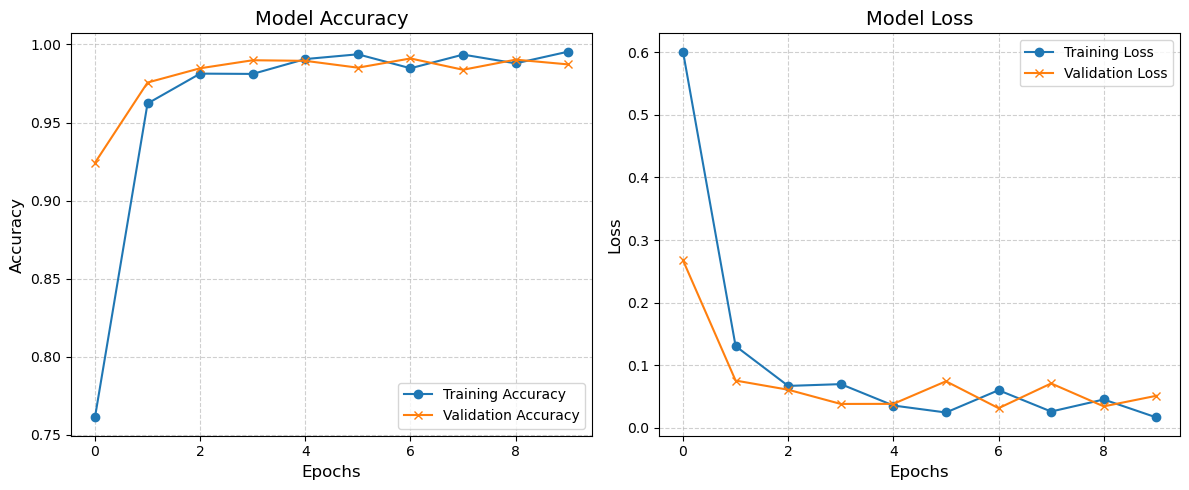

In [20]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Adjusted figure size for better clarity
ax = ax.flatten()

# Plot accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
ax[0].set_title('Model Accuracy', fontsize=14)
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.6)
ax[0].legend(fontsize=10)

# Plot loss
ax[1].plot(history.history['loss'], label='Training Loss', marker='o')
ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='x')
ax[1].set_title('Model Loss', fontsize=14)
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend(fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


**Comment**

- The model achieves **~99% accuracy** and **less than 0.1 loss**.
- Both the training and validation datasets show similar performance, indicating that there is **no overfitting**.


### Evaluating Model Performance on the Test Dataset

165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1037
           1       0.97      1.00      0.99      1058
           2       0.99      0.98      0.99      1054
           3       0.99      0.98      0.99      1028
           4       1.00      1.00      1.00      1073

    accuracy                           0.99      5250
   macro avg       0.99      0.99      0.99      5250
weighted avg       0.99      0.99      0.99      5250



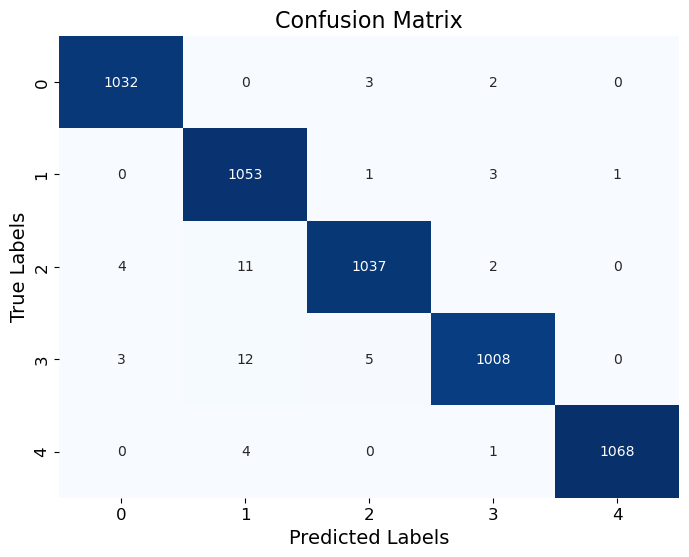

In [21]:
# Generate predictions
y_test_predictions_probs = model.predict(X_test)
y_test_predictions = np.argmax(y_test_predictions_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_test_predictions)
print(f"Accuracy: {accuracy:.2f}\n")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_test_predictions))

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_predictions)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Pros and Cons of Gesture Detection Using Range-Doppler Profiles

### Advantages
1. **Comprehensive Data**  
   - Range-Doppler profiles provide both distance and velocity information, allowing for accurate analysis of gesture dynamics.

2. **Efficient Data Processing**  
   - Once range-Doppler profiles are generated, deep learning models can process the data directly for gesture recognition, minimizing the need for extensive post-processing.

### Disadvantages
1. **High Dimensionality**  
   - Range-Doppler profiles are large in size, making them computationally expensive to store and process without optimized techniques.


# SECTION 2
Since gesture detection and classification using range-Doppler profiles is computationally expensive, this section focuses on extracting key features from both range-Doppler and range profiles using signal processing techniques, as outlined in the [reference paper](https://arxiv.org/pdf/2310.08876). These lightweight features enable efficient model application for gesture recognition.

# Part 1: Load Data  

- **Data Overview**:  
  Radar signals are stored as NumPy arrays with a shape of `(100x3x32x64)`, resulting in a total data size of 52 GB.  

- **Challenge**:  
  Loading all the data directly is impractical due to its large size.  

- **Solution**:  
  Light weight features will be extracted iteratively using the preprocessed functions created earlier and saved to a dictionary.  

#### Steps for Processing:  
1. **Load Data Points**:  
   - Retrieve data from the specified folder.  
   - Extract features such as:  
     - Range  
     - Doppler  
     - Signal magnitude  
     - Horizontal angle  
     - Vertical angle  

2. **Extract metadata from File Names**:  
   - Extract metadata, including:  
     - Gesture names  
     - Environment labels  
     - User labels
3. Create a pandas **dataframe**




In [22]:
DATA_FOLDER = './fulldata'

# Initialize a dictionary to store the data
full_data = {
    'file_name':[],
    'avg_range':[],
    'avg_doppler':[],
    'avg_magnitude':[],
    'avg_horizontal_angle':[],
    'avg_vertical_angle':[],
    'gesture_name': [],
    'environment_label': [],
    'user_label': []
}

# Iterate over files in the data folder
for file_name in os.listdir(DATA_FOLDER):
    # Construct the full path to the file
    full_data_path = os.path.join(DATA_FOLDER, file_name)

    # upload data
    data = np.load(full_data_path)
    
    # calculate range
    integrated_range_fft = generate_range_profiles(data)
    range_bins = detect_hand_position(integrated_range_fft)
    range_ = calculate_range(integrated_range_fft)
    #full_data['range_'].append(range_)
    selected_frames = select_frames(range_)
    full_data['avg_range'].append(np.mean(range_[selected_frames])) # average range of selected frames

    # calculate doppler
    integrated_range_doppler_profiles = generate_range_doppler_profiles(data)
    doppler_bins = calculate_doppler_bins(integrated_range_doppler_profiles, range_bins)
    doppler = calculate_radial_speed(integrated_range_doppler_profiles, range_bins)
    #full_data['doppler'].append(doppler)
    full_data['avg_doppler'].append(np.mean(doppler[selected_frames])) #  average doppler of selected frames

    # calculate signal magnitude
    signal_magnitude = calculate_signal_magnitude(integrated_range_doppler_profiles, range_bins, doppler_bins)
    #full_data['signal_magnitude'].append(signal_magnitude)
    full_data['avg_magnitude'].append(np.mean(signal_magnitude[selected_frames]))  #average magnitude of selected frames

    # calculate horizontal and vertical angles
    range_doppler_profiles_per_antenna = generate_range_doppler_profiles_per_antenna(data)
    horizontal_angle, vertical_angle = extract_angles(range_doppler_profiles_per_antenna, doppler_bins, range_bins)
    #full_data['horizontal_angle'].append(horizontal_angle)
    #full_data['vertical_angle'].append(vertical_angle)
    full_data['avg_horizontal_angle'].append(np.mean(horizontal_angle[selected_frames]))
    full_data['avg_vertical_angle'].append(np.mean(vertical_angle[selected_frames])) # average vertical angle of selected frames
    # Parse the filename to extract labels
    try:
        gesture_name, environment_label, user_label, _ = file_name.split('_')
        full_data['gesture_name'].append(gesture_name)
        full_data['environment_label'].append(environment_label)
        full_data['user_label'].append(user_label)
        full_data['file_name'].append(file_name)
    except ValueError:
        print(f"Filename format is incorrect: {file_name}")
        continue  # Skip if the filename format is invalid


In [23]:
df_full_data = pd.DataFrame.from_dict(full_data)

# Part 2: Analysis of Preprocessed Data  

In [24]:
# Take a look at the data
df_full_data.head()

,file_name,avg_range,avg_doppler,avg_magnitude,avg_horizontal_angle,avg_vertical_angle,gesture_name,environment_label,user_label
0,SwipeUp_e5_u1_s247.npy,0.534639,-0.88536,5.851071,-0.108649,0.003541,SwipeUp,e5,u1
1,SwipeUp_e4_u1_s323.npy,0.374611,-1.32804,4.185153,0.180168,-0.076059,SwipeUp,e4,u1
2,SwipeRight_e1_u3_s71.npy,0.694667,-0.15624,1.043574,-0.350277,-0.184827,SwipeRight,e1,u3
3,Push_e4_u1_s114.npy,0.116384,0.00000,25.255797,-0.371022,-0.241273,Push,e4,u1
4,SwipeRight_e1_u4_s114.npy,0.552824,1.01556,1.941961,-0.913163,-0.096587,SwipeRight,e1,u4


In [25]:
df_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   file_name             21000 non-null  object 
 1   avg_range             21000 non-null  float64
 2   avg_doppler           21000 non-null  float64
 3   avg_magnitude         21000 non-null  float64
 4   avg_horizontal_angle  21000 non-null  float64
 5   avg_vertical_angle    21000 non-null  float64
 6   gesture_name          21000 non-null  object 
 7   environment_label     21000 non-null  object 
 8   user_label            21000 non-null  object 
dtypes: float64(5), object(4)
memory usage: 1.4+ MB


### Comments on Data:

- **No Null Data**:  
  The dataset does not contain any null or missing values.

- **Categorical Columns**:  
  - `file_name`, `gesture_name`, `environment_label`, and `user_label` are correctly parsed as **object** (string) data types. `gesture_name` will be the target variable as this project aims to classify gestures.

- **Numerical Features**:  
  - `avg_range`, `avg_doppler`, `avg_magnitude`, `avg_horizontal_angle`, and `avg_vertical_angle` are correctly parsed as **float** data types.

### Data Distribution Across Different Environments

Radar signals were collected in various environments, including:
- **Gym**
- **Library**
- **Kitchen**
- **Bedroom**
- **Shared Office Room**
- **Closed Meeting Room**

Let's look at the data distribution within the dataset across these environments.

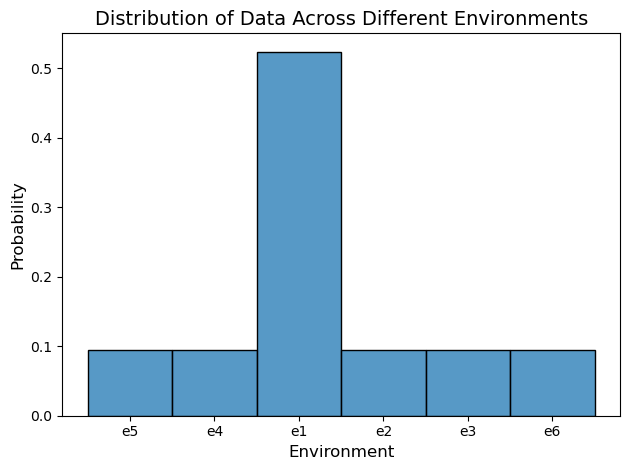

In [26]:
sns.histplot(data=df_full_data, x='environment_label', stat='probability')
plt.xlabel("Environment", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Distribution of Data Across Different Environments", fontsize=14)
plt.tight_layout()
plt.show()

**Comment**

Half of the data was collected in Environment 1, while the remaining environments contributed approximately equal amounts of data.

### Data Distribution Across Individual Gesture Performers

A total of 8 individuals performed 5 different gestures. Let's investigate the distribution of data across these individuals.


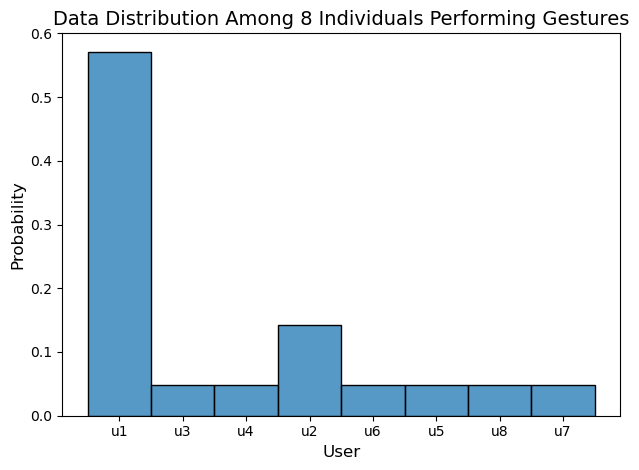

In [27]:
sns.histplot(data=df_full_data, x='user_label', stat='probability')
plt.xlabel("User", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Data Distribution Among 8 Individuals Performing Gestures", fontsize=14)
plt.tight_layout()
plt.show()

**Comment**

More than half of the data was contributed by Individual 1, while the remaining individuals provided approximately equal amounts of data.

## Data Preparation for the Model

### Encode Categorical Predictors

In [28]:
# Encode categorical colums environment_label and user_label
df_full_data_encoded = pd.get_dummies(df_full_data, columns=['environment_label', 'user_label'], prefix=['env', 'user'], drop_first=True, dtype=int)

# Drop 'gesture_name' as it is the target variable and 'file_name' as it is irrelevant to the model.
df_full_data_encoded = df_full_data_encoded.drop(['gesture_name', 'file_name'], axis=1) 

### Scale the Data

In [29]:
# Scale the data 
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
df_full_data_encoded_scaled  = scaler.fit_transform(df_full_data_encoded) 

df = pd.DataFrame(df_full_data_encoded_scaled, columns=df_full_data_encoded.columns)
df.head()

,avg_range,avg_doppler,avg_magnitude,avg_horizontal_angle,avg_vertical_angle,env_e2,env_e3,env_e4,env_e5,env_e6,user_u2,user_u3,user_u4,user_u5,user_u6,user_u7,user_u8
0,0.428476,-1.476351,0.025429,1.051355,0.153056,-0.324443,-0.324443,-0.324443,3.082207,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
1,-0.439329,-2.097879,-0.201119,2.435934,-0.181045,-0.324443,-0.324443,3.082207,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
2,1.296282,-0.452657,-0.628340,-0.107003,-0.637568,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,4.472136,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
3,-1.839652,-0.233294,2.664265,-0.206453,-0.874486,-0.324443,-0.324443,3.082207,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
4,0.527090,1.192565,-0.506169,-2.805463,-0.267207,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,4.472136,-0.223607,-0.223607,-0.223607,-0.223607


### Prepare the target variable

In [30]:
# Map gesture names to numerical labels using a dictionary
gesture_dict = {
    'SwipeLeft': 0, 
    'SwipeRight': 1, 
    'SwipeDown': 2, 
    'SwipeUp': 3, 
    'Push': 4
}

# Create the target labels column
df['target'] = df_full_data['gesture_name'].map(gesture_dict)
df.head()

,avg_range,avg_doppler,avg_magnitude,avg_horizontal_angle,avg_vertical_angle,env_e2,env_e3,env_e4,env_e5,env_e6,user_u2,user_u3,user_u4,user_u5,user_u6,user_u7,user_u8,target
0,0.428476,-1.476351,0.025429,1.051355,0.153056,-0.324443,-0.324443,-0.324443,3.082207,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,3
1,-0.439329,-2.097879,-0.201119,2.435934,-0.181045,-0.324443,-0.324443,3.082207,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,3
2,1.296282,-0.452657,-0.628340,-0.107003,-0.637568,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,4.472136,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,1
3,-1.839652,-0.233294,2.664265,-0.206453,-0.874486,-0.324443,-0.324443,3.082207,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,4
4,0.527090,1.192565,-0.506169,-2.805463,-0.267207,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,4.472136,-0.223607,-0.223607,-0.223607,-0.223607,1


### Prepare Train/Test Set

In [31]:
X = df.drop(['target'], axis=1)

# Define the target variable
y = df['target']

In [32]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.5, stratify=y, shuffle=True) 

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10500 entries, 14290 to 2543
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_range             10500 non-null  float64
 1   avg_doppler           10500 non-null  float64
 2   avg_magnitude         10500 non-null  float64
 3   avg_horizontal_angle  10500 non-null  float64
 4   avg_vertical_angle    10500 non-null  float64
 5   env_e2                10500 non-null  float64
 6   env_e3                10500 non-null  float64
 7   env_e4                10500 non-null  float64
 8   env_e5                10500 non-null  float64
 9   env_e6                10500 non-null  float64
 10  user_u2               10500 non-null  float64
 11  user_u3               10500 non-null  float64
 12  user_u4               10500 non-null  float64
 13  user_u5               10500 non-null  float64
 14  user_u6               10500 non-null  float64
 15  user_u7              

In [34]:
# Getting know the data
X_train.describe()

,avg_range,avg_doppler,avg_magnitude,avg_horizontal_angle,avg_vertical_angle,env_e2,env_e3,env_e4,env_e5,env_e6,user_u2,user_u3,user_u4,user_u5,user_u6,user_u7,user_u8
count,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,1.050000e+04,10500.000000,10500.000000,10500.000000
mean,-0.004380,-0.001964,0.012340,-0.007667,-0.002942,0.008111,-0.012978,0.000973,-0.008760,0.004218,0.012247,0.008497,0.002236,-5.041470e-17,-0.006708,-0.005814,-0.004025
std,1.005609,1.000202,1.030305,1.002933,1.000940,1.011138,0.981903,1.001388,0.987855,1.005838,1.012397,1.017903,1.004784,1.000048e+00,0.985671,0.987603,0.991452
min,-1.879098,-3.267814,-0.756400,-3.920257,-3.046716,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-2.236068e-01,-0.223607,-0.223607,-0.223607
25%,-0.774618,-0.745141,-0.445734,-0.649850,-0.560991,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-2.236068e-01,-0.223607,-0.223607,-0.223607
50%,-0.005427,0.095750,-0.266377,0.059367,-0.146865,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-2.236068e-01,-0.223607,-0.223607,-0.223607
75%,0.842656,0.826960,-0.002905,0.745812,0.468645,-0.324443,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-2.236068e-01,-0.223607,-0.223607,-0.223607
max,2.440207,2.545303,12.922209,4.710797,3.745211,3.082207,3.082207,3.082207,3.082207,3.082207,2.449490,4.472136,4.472136,4.472136e+00,4.472136,4.472136,4.472136


**Comment**

The statistics above show that the range (distance) values vary between ~0.90 and ~0.10. This aligns with the device's configuration, which is capable of measuring objects within a range of 1.2 meters to 0.0375 meters.

The Doppler (velocity) values range from ~-2 to ~1.7. A **negative Doppler shift** indicates that the object is moving **away** the sensor, while a **positive Doppler shift** indicates that the object is moving **towards** from the sensor.



### Visualize the training data on Reduced Dimensional Space 

In [35]:
# Select features 
extracted_features = ['avg_range', 'avg_doppler', 'avg_magnitude', 'avg_horizontal_angle', 'avg_vertical_angle']

#### 1. Visualize by PCA

Explained Variance by each component: [0.34 0.25]
Total Explained Variance: 0.5900000000000001


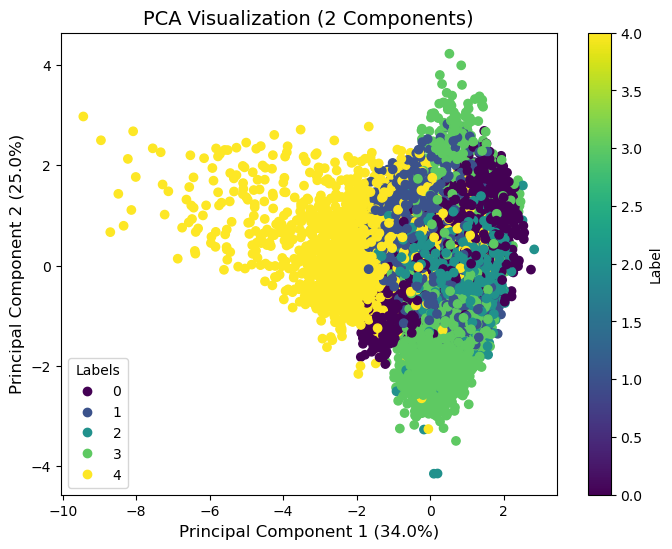

In [36]:
# Set the number of components for PCA
n_components = 2

# Apply PCA to the training data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train[extracted_features])

# Get the explained variance ratio to understand the data retained
explained_variance = np.round(pca.explained_variance_ratio_, 2)

# Print explained variance
print(f"Explained Variance by each component: {explained_variance}")
print(f"Total Explained Variance: {explained_variance.sum()}")

# Create a scatter plot to visualize the reduced data
plt.figure(figsize=(8, 6))

# Scatter plot with color mapping based on labels
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')

# Add legends
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Labels")

# Add titles and labels with formatted text for explained variance
plt.title("PCA Visualization (2 Components)", fontsize=14)
plt.xlabel(f"Principal Component 1 ({explained_variance[0] * 100}%)", fontsize=12)
plt.ylabel(f"Principal Component 2 ({explained_variance[1] * 100}%)", fontsize=12)

# Color bar to show the labels
plt.colorbar(label="Label")

# Display the plot
plt.show()


### Comment

Although PCA captures a high explained variance, the gestures mostly overlap with each other in the reduced dimensional space. 

For reference, the gesture labels are as follows:
- **SwipeLeft**: 0
- **SwipeRight**: 1
- **SwipeDown**: 2
- **SwipeUp**: 3
- **Push**: 4

The **Push** gesture is relatively well-separated from the other gestures in the visualization.

#### 2. Visualize by LDA

Explained Variance Ratio: [0.56417394 0.23830137 0.12497141 0.07255329]
Total Explained Variance: 0.9999999999999999


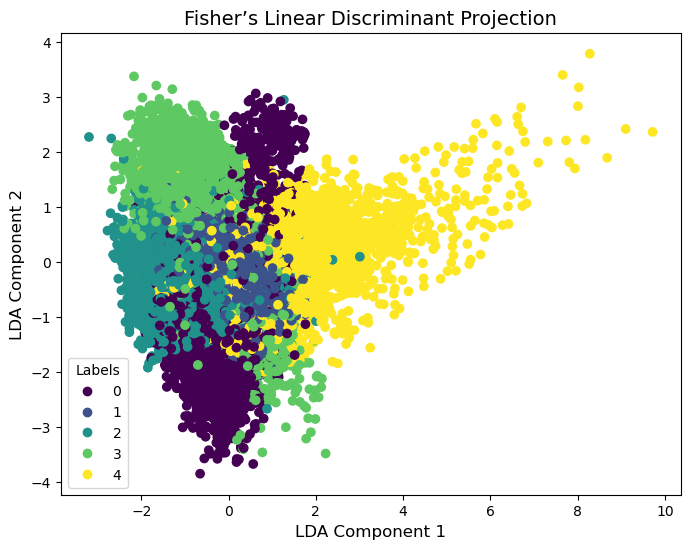

In [37]:
n_components = y_train.nunique() - 1  # Set to the number of classes minus one for maximum separability

# Initialize LDA and fit-transform the data
lda = LinearDiscriminantAnalysis(n_components=n_components)
lda_components = lda.fit_transform(X_train[extracted_features], y_train)

# Display explained variance ratio
explained_variance = lda.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance}")
print(f"Total Explained Variance: {explained_variance.sum()}")


plt.figure(figsize=(8, 6))
scatter = plt.scatter(lda_components[:,0], lda_components[:,1], c=y_train)
plt.title("Fisher’s Linear Discriminant Projection", fontsize=14)
plt.xlabel("LDA Component 1", fontsize=12)
plt.ylabel("LDA Component 2", fontsize=12)

# Add legends
handles, labels = scatter.legend_elements()
plt.legend(handles, labels, title="Labels")

plt.show()

**Comment**

Dimensionality reduction using **Linear Discriminant Analysis (LDA)** appears to perform better than PCA. While some gestures still show overlap, there is a noticeable improvement in the separation between the five gestures.


### Can Gestures Be Clustered Based on the Individuals Who Performed Them?

### Gesture Dataset Overview

The dataset includes data from 8 individuals who performed various gestures: **SwipeUp**, **SwipeDown**, **SwipeRight**, **SwipeLeft**, and **Push**. Each gesture is characterized by 5 features:
- Range
- Doppler
- Signal Magnitude
- Horizontal Angle
- Vertical Angle

### Research Question

The research question is whether any of the features can be used to distinctly identify the individual who performed the gesture.

To explore this, let's visualize the data and color it according to the gesture performers.


In [38]:
user_dict = {'u1': 1, 'u2':2, 'u3':3, 'u4':4, 'u5':5, 'u6':6, 'u7':7, 'u8':8}
users_full_data = df_full_data['user_label'].apply(lambda x: user_dict[x])
users_train = users_full_data[X_train.index]

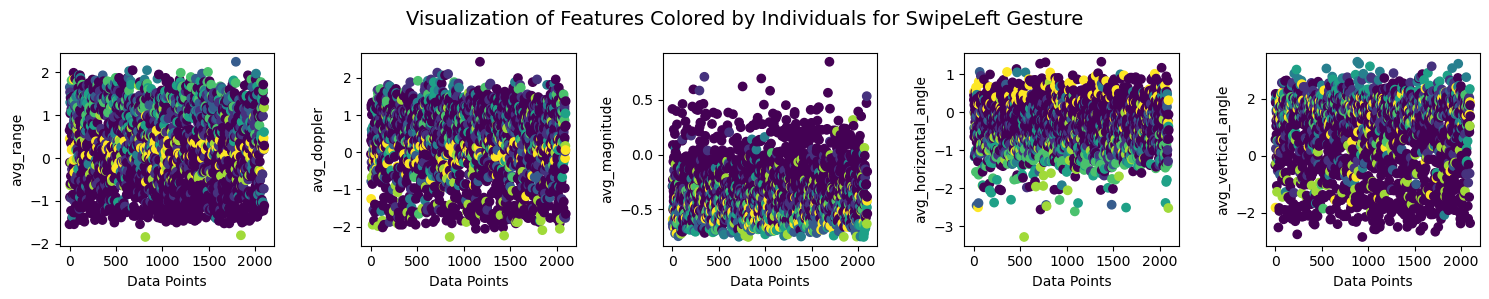

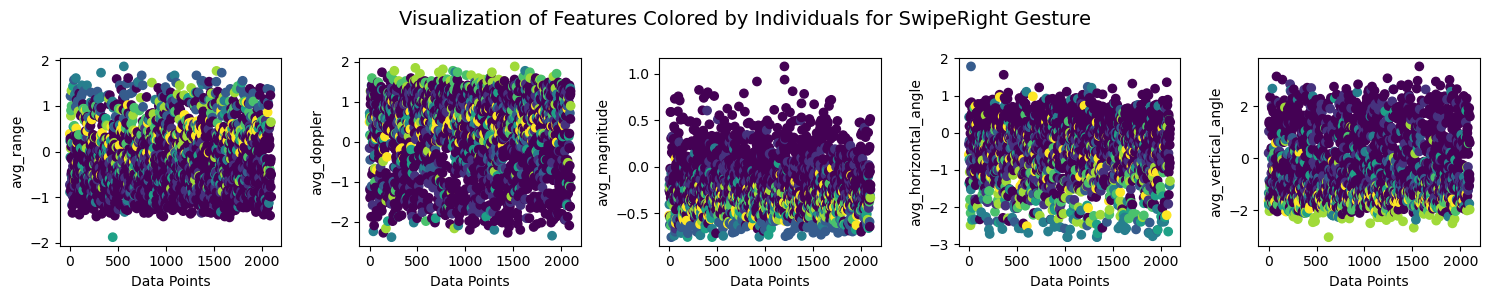

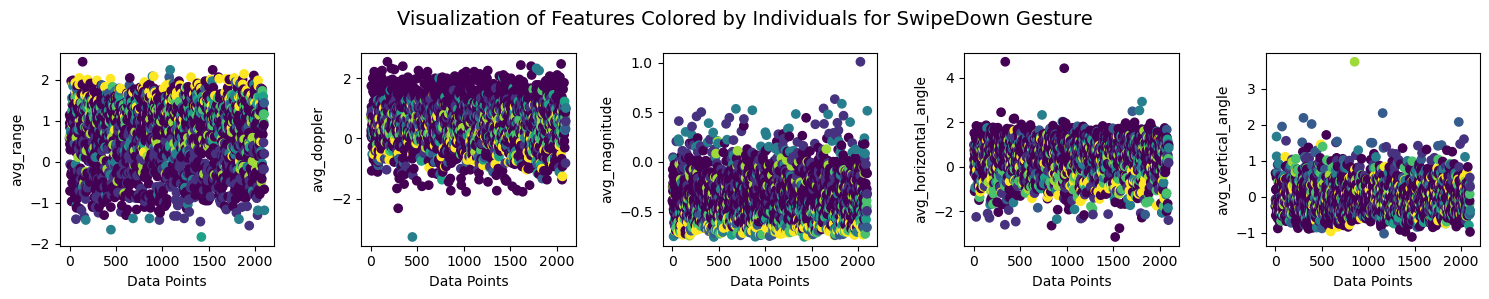

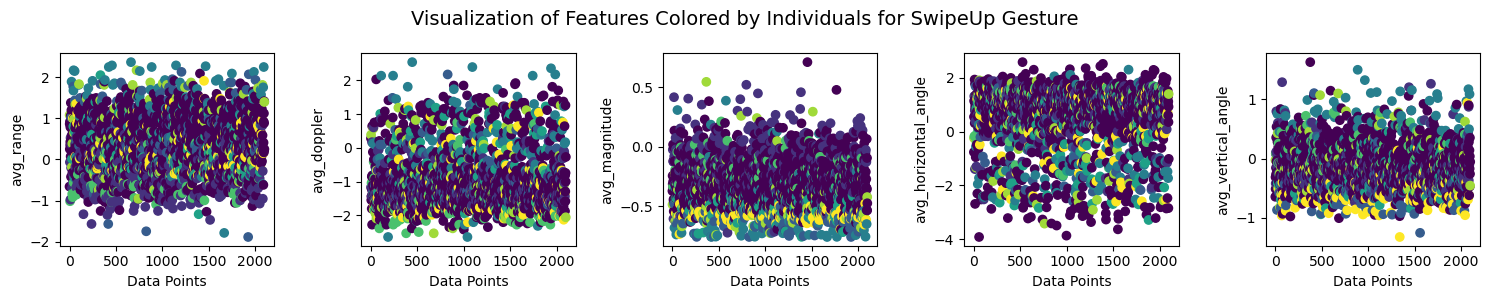

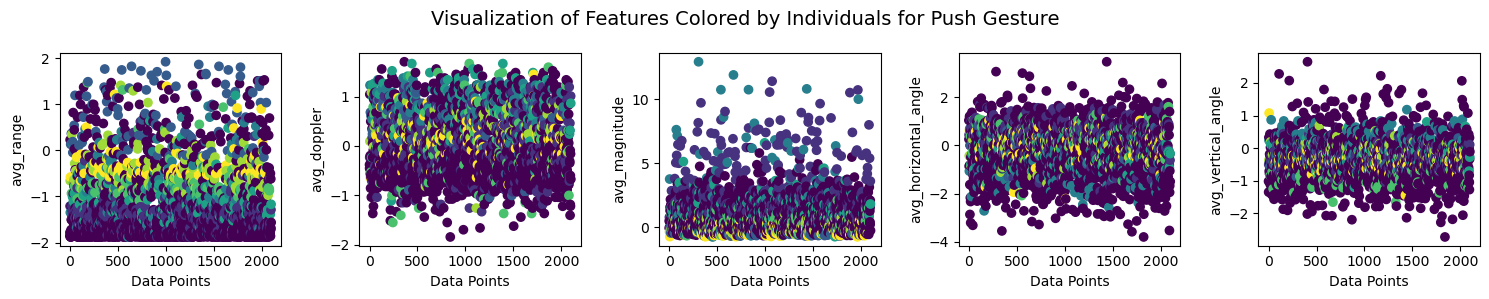

In [39]:
# Function to plot feature visualizations for a given gesture
def plot_gesture_features(gesture_label, gesture_name, data, target, features, users):
    fig, ax = plt.subplots(1, 5, figsize=(15, 3))
    ax = ax.flatten()
    
    # Filter data for the given gesture
    data_points = np.arange(0, data[target == gesture_label].shape[0], 1)
    
    # Plot each feature
    for i, feature in enumerate(extracted_features):
        ax[i].scatter(data_points, data[target == gesture_label][feature], c=users[target == gesture_label])
        ax[i].set_xlabel("Data Points")
        ax[i].set_ylabel(feature)
    
    # Title and layout adjustments
    plt.suptitle(f"Visualization of Features Colored by Individuals for {gesture_name} Gesture", fontsize=14)
    plt.tight_layout()
    plt.show()

# List of gestures and their labels
gestures = [(0, 'SwipeLeft'), (1, 'SwipeRight'), (2, 'SwipeDown'), (3, 'SwipeUp'), (4, 'Push')]

# List the features of interest
features = ['avg_range',
 'avg_doppler',
 'avg_magnitude',
 'avg_horizontal_angle',
 'avg_vertical_angle']

# Iterate over each gesture and generate the plot
for gesture_label, gesture_name in gestures:
    plot_gesture_features(gesture_label, gesture_name, X_train, y_train, features, users_train)


**Comment**

The above visualization suggests that there are no distinct personal traits identifiable in the data.


### Investigating the Importance of Features

#### 1. Determining Feature Importance with RandomForestClassifier

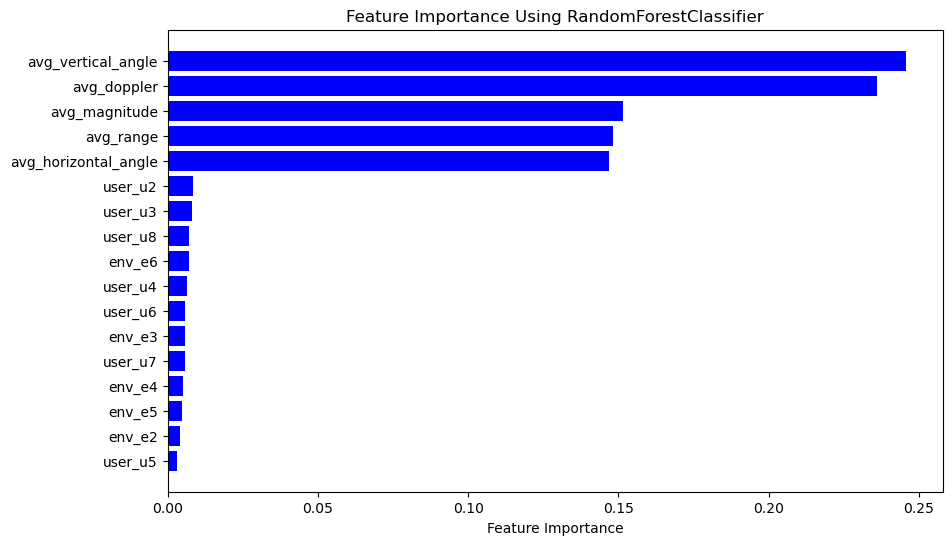

In [40]:
# Create a Random Forest classifier
rf = RandomForestClassifier()

# Fit the classifier to the data
rf.fit(X_train, y_train)

# Get feature importance   
feature_importance_rf = rf.feature_importances_

# Create a DataFrame with feature names and importances
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance_rf
})

# Sort the DataFrame by importance
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color='blue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Using RandomForestClassifier')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

**Comment**  
Feature importance analysis shows that **vertical angle** and **Doppler** are the key factors in gesture classification, while the **measurement location** and **gesture performer** have less impact.


## Classification  of Gestures Using Gradient Boosing Classifier

# Method 1  
Perform classification using features extracted from radar signals, excluding the gesture performer and environment variables.


In [41]:
# List the features of interest
features = ['avg_range',
 'avg_doppler',
 'avg_magnitude',
 'avg_horizontal_angle',
 'avg_vertical_angle']

In [42]:
param_grid = {
    'n_estimators':[100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
}

gb_classifier = GradientBoostingClassifier(
    learning_rate=0.1, 
    random_state=42
)

# Initialize GridSearchCV

grid_search_1 = GridSearchCV(
    estimator=gb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

grid_search_1.fit(X_train[features], y_train)


print("Best Parameters:", grid_search_1.best_params_)
print("Best Accuracy:", grid_search_1.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy: 0.8814285714285715


### Evaluating Model Performance on the Test Dataset

Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.89      2100
           1       0.87      0.91      0.89      2100
           2       0.83      0.87      0.85      2100
           3       0.91      0.89      0.90      2100
           4       0.90      0.88      0.89      2100

    accuracy                           0.88     10500
   macro avg       0.88      0.88      0.88     10500
weighted avg       0.88      0.88      0.88     10500



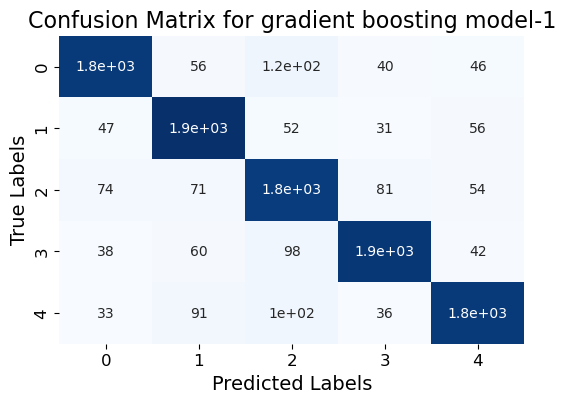

In [43]:
# Generate predictions
y_test_predictions_method_1 = grid_search_1.predict(X_test[features])

# Calculate accuracy
accuracy_1 = accuracy_score(y_test, y_test_predictions_method_1)
print(f"Accuracy: {accuracy_1:.2f}\n")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_test_predictions_method_1))

# Generate confusion matrix
conf_matrix_1 = confusion_matrix(y_test, y_test_predictions_method_1)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_1, annot=True, cmap="Blues", cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for gradient boosting model-1", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Method 2  
Perform classification using features extracted from radar signals, including information about the gesture performer.


In [44]:
# List the features of interest
features_with_gesture_performers = ['avg_range', 'avg_doppler', 'avg_magnitude', 'avg_horizontal_angle', 'avg_vertical_angle','user_u2', 'user_u3', 'user_u4', 'user_u5', 'user_u6', 'user_u7','user_u8']

param_grid = {
    'n_estimators':[100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
}

gb_classifier = GradientBoostingClassifier(
    learning_rate=0.1, 
    random_state=42
)

# Initialize GridSearchCV

grid_search_2 = GridSearchCV(
    estimator=gb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

grid_search_2.fit(X_train[features_with_gesture_performers], y_train)


print("Best Parameters:", grid_search_2.best_params_)
print("Best Accuracy:", grid_search_2.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best Accuracy: 0.9105714285714285


### Evaluating Model Performance on the Test Dataset

Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      2100
           1       0.90      0.94      0.92      2100
           2       0.87      0.89      0.88      2100
           3       0.93      0.90      0.91      2100
           4       0.95      0.94      0.94      2100

    accuracy                           0.91     10500
   macro avg       0.91      0.91      0.91     10500
weighted avg       0.91      0.91      0.91     10500



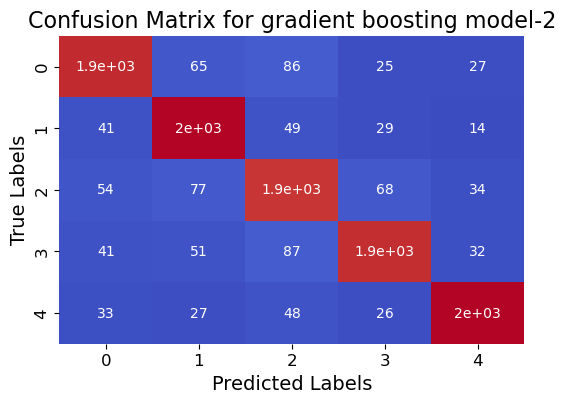

In [45]:
# Generate predictions
y_test_predictions_method_2 = grid_search_2.predict(X_test[features_with_gesture_performers])

# Calculate accuracy
accuracy_2 = accuracy_score(y_test, y_test_predictions_method_2)
print(f"Accuracy: {accuracy_2:.2f}\n")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_test_predictions_method_2))

# Generate confusion matrix
conf_matrix_2 = confusion_matrix(y_test, y_test_predictions_method_2)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_2, annot=True, cmap="coolwarm", cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for gradient boosting model-2", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Comment**  
Although metadata extracted from file names (e.g. gesture performers (users)) are the least important features, they still contribute to an increase in model performance, boosting accuracy from 88% to 91%, revealing that there are individual traits during performing of gestures.


# Method 3  
Perform classification using features extracted from radar signals, combined with metadata-derived features, including the gesture performer and environment variables.

In [46]:
param_grid = {
    'n_estimators':[100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
}

gb_classifier = GradientBoostingClassifier(
    learning_rate=0.1, 
    random_state=42
)

# Initialize GridSearchCV

grid_search_3 = GridSearchCV(
    estimator=gb_classifier,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

grid_search_3.fit(X_train, y_train)


print("Best Parameters:", grid_search_3.best_params_)
print("Best Accuracy:", grid_search_3.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
Best Accuracy: 0.9160952380952381


### Evaluating Model Performance on the Test Dataset

Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      2100
           1       0.91      0.94      0.92      2100
           2       0.90      0.90      0.90      2100
           3       0.93      0.91      0.92      2100
           4       0.96      0.95      0.95      2100

    accuracy                           0.92     10500
   macro avg       0.92      0.92      0.92     10500
weighted avg       0.92      0.92      0.92     10500



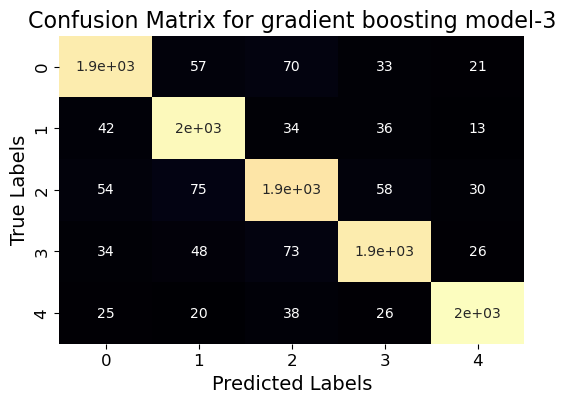

In [47]:
# Generate predictions
y_test_predictions_method_3 = grid_search_3.predict(X_test)

# Calculate accuracy
accuracy_3 = accuracy_score(y_test, y_test_predictions_method_3)
print(f"Accuracy: {accuracy_3:.2f}\n")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_test_predictions_method_3))

# Generate confusion matrix
conf_matrix_3 = confusion_matrix(y_test, y_test_predictions_method_3)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_3, annot=True, cmap="magma", cbar=False, 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for gradient boosting model-3", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**Comment**  
Including the measurement location increased the model's accuracy from 91% to 92%.

## Summary

The Gradient Boosting algorithm, paired with grid search for optimal parameter tuning, is employed to classify gestures.

- The first approach utilizes only radar-based features, achieving an accuracy of 88%.  
- The second approach introduces the gesture performer as an additional feature, boosting the model's accuracy to 91%.  
- The third model includes both the gesture performer and measurement location, in addition to radar-based features, further improving accuracy to 92%.


### Use a Simpler Model and Leverage SHAP for Model Explanations

In [48]:
# Initialize and train the Decision Tree model
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)

# Make predictions on the training set
train_predictions = decision_tree_model.predict(X_train)

# Calculate and print training accuracy
training_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy of the Decision Tree Model: {training_accuracy:.2f}")

Training Accuracy of the Decision Tree Model: 1.00


In [49]:
# Make predictions on the test set
test_predictions = decision_tree_model.predict(X_test)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy of the Decision Tree Model: {test_accuracy:.2f}")

Test Accuracy of the Decision Tree Model: 0.87


In [50]:
# Initialize SHAP's JavaScript visualization
shap.initjs()

# Create a SHAP Kernel Explainer
explainer = shap.KernelExplainer(
    model=decision_tree_model.predict, 
    data=X_test.head(50), 
    link="identity"
)

# Index of the instance(s) to explain
instance_index = 0

# Calculate SHAP values for the selected instance(s)
shap_values_single = explainer.shap_values(
    X=X_test.iloc[instance_index : instance_index + 3, :], 
    nsamples=100
)

# Display the data for the selected instance(s)
X_test.iloc[instance_index : instance_index + 3, :]

  0%|          | 0/3 [00:00<?, ?it/s]

,avg_range,avg_doppler,avg_magnitude,avg_horizontal_angle,avg_vertical_angle,env_e2,env_e3,env_e4,env_e5,env_e6,user_u2,user_u3,user_u4,user_u5,user_u6,user_u7,user_u8
7341,-1.741038,-0.050492,0.928682,-0.882560,-0.944133,-0.324443,-0.324443,3.082207,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
20244,0.310139,1.960335,-0.186770,1.233727,0.052400,-0.324443,-0.324443,3.082207,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
12429,1.217390,-1.220427,-0.423426,-0.671603,1.287873,3.082207,-0.324443,-0.324443,-0.324443,-0.324443,-0.408248,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607


**Comment**  
The above DataFrame highlights the contribution of each feature to the model's classification decision. For example:  
- For the data point with index **20244**, the feature **doppler** makes a **positive contribution** to the overall classification score.  
- In contrast, for the other two instances, **doppler** has a **negative contribution** to the classification score.  
This demonstrates how individual features influence the model's predictions differently for each instance.
